# In this assignment we learn how to derive a neural network emultor based on the cosmopower emulator (Mancini et al. 2021). Based on this emualtor we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
from cosmopower_NN import cosmopower_NN

## Preparation: load in the all the 10000 model vectors and corresponding parameters that we use to bulit the emulator.

In [2]:
models = np.load('data_4_assignment2/models.npy') 
parameters = np.load('data_4_assignment2/parameters.npz')

# Checking the shape of the model and the parameter names
parameters.keys(),models.shape

(KeysView(NpzFile 'data_4_assignment2/parameters.npz' with keys: omega_m, omega_b, As, w),
 (10000, 900))

#### Divide the models and parameters in a training and test set. 

In [3]:
train_sample = np.arange(0,7000) # select which elements you wanna use for training
test_sample = np.arange(7000,10000) # select which elements you wanna use for training

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])
    
test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = np.load('data_4_assignment2/models.npy')[train_sample]
test_features = np.load('data_4_assignment2/models.npy')[test_sample]

# Verifying the shape of the test and train features
print(test_features.shape)
print(train_features.shape)

(3000, 900)
(7000, 900)


#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [4]:
# Try dividing the train_features by the standard deviation
"""features_modified = train_features / np.std(train_features)"""

# Try normalizing everything between 0 and 1. So subtract the minimum and divide by the min subtracted maximum
minimum_feature = np.min(train_features, axis=0)
maximum_feaure = np.max(train_features - minimum_feature, axis=0)

features_modified = train_features - minimum_feature
features_modified = features_modified/maximum_feaure

# Initializaing the cosmopower Neural Network object with 1 input layer, 2 hidden layers and 1 output layer with 512 neurons each
cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [ 512, 512, 512, 512], # This you should modify. In this exmaple we use three layers with 4, 5 and 6 nodes. Is this enough?
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

device = 'cpu' # Tensorflow is not able to detect my GPU :(
with tf.device(device):
    # Training the Neural Network
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                filename_saved_model='data_4_assignment2/emulator_test_norm_v3_500', # the name of the emulator and where to save it
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates. This need to be adjusted
                
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                # the batch size is the number of samples from the training set to pass through the Neural Network. Generally, lower batch sizes
                # leads to less accurate estimates of the gradient which impacts the overal loss and accuracy of the NN
                
                gradient_accumulation_steps = [1, 1, 1, 1, 1],
                
                patience_values = [100, 100, 100, 100, 100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                
                max_epochs = [1000, 1000, 1000, 1000, 1000] # Maxmimal number of epoch before decreasing the learning rate
                )



Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


 36%|███▌      | 358/1000 [04:14<07:35,  1.41it/s, loss=0.00302]


Validation loss = 0.0024481877
Model saved.
Reached max number of epochs. Validation loss = 0.0024481877
Model saved.
learning rate = 0.001, batch size = 500


 25%|██▍       | 249/1000 [03:01<09:06,  1.38it/s, loss=0.000582]


Validation loss = 0.00028477868
Model saved.
Reached max number of epochs. Validation loss = 0.00028477868
Model saved.
learning rate = 0.0001, batch size = 500


100%|██████████| 1000/1000 [11:23<00:00,  1.46it/s, loss=0.000107]


Reached max number of epochs. Validation loss = 0.00010310946
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 103/1000 [01:10<10:15,  1.46it/s, loss=8.3e-5] 


Validation loss = 8.132023e-05
Model saved.
Reached max number of epochs. Validation loss = 8.132023e-05
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 100/1000 [01:08<10:20,  1.45it/s, loss=8.39e-5]

Validation loss = 8.284143e-05
Model saved.
Reached max number of epochs. Validation loss = 8.284143e-05
Model saved.


## Comments on the Various Training Parameters:

Learning Rate:
- the value speicifed is the optimizers learning rate at each step
- We need to start with a appropriatly large learning rate and decrease it with subsequenct steps (for example, I started from 1e-1 and end with 1e-6)
- If the learning rate is too high then the optimizer will jump around and never find a minimum (whether that is a local or global minimum). So the loss will fluctuate alot but never seem to converge. 
- The goal is to start with a large enough learning rate that it can explore the optimziation space sufficiently and quickly find the global minimum. The smaller learning rates afterwards are used to get more precise traning values and better loss values. 


Batch Size:
- the batch size controls how many elements of the traning set is thrown into the neural network at once. In my case, the batch size is 500 which it will throw the 7000 training samples into the NN in batches of 500 fourteen times.
- Intuition tells me that, we should use a batch size value which is a multiply of the overal training sample size (7000/500 = 14). This ensures that every batch going into the NN is the same size. Smaller sized or larger sizes batches from previous ones might lead to inaccurate results (?)

Max Epochs:
- this parameters cotrols the max number of epochs to cycle through before the NN goes to the next learning rate. This parameters goes hand-in-hand with the patience value. If the loss doesn't change according to the number of epochs sepcified by the patience value then the NN will automatically move to the next learning rate even if the max epochs wasn't reached.

Number of Neurons:
- Having too little neurons in our nodes/layers would result in underfitting of the data and a larger loss while training
- Having too many neurons in our nodes/layers would resutl in overfitting of the data. Depending on the model being trained, in theory there will be a max number of neurons after which, further increasing the number of neurons will be extremely computationally expensive and the resulting loss will not be significantly better
- In the case of our model here, since it is noise free we want to overfit/train our emulator so having a large number of neurons and layers is good for us.


In [6]:
# Loading an already saved/run emulator instance so I don't need to keep retraining all the time
#cp_nn = cosmopower_NN(restore=True, restore_filename='data_4_assignment2/emulator_test_norm_v2')

# Checking the version of Tensorflow
#tf.__version__

#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

In [13]:
# emulated features retrieved from the NN using the test parameters
emulated_features = cp_nn.predictions_np(test_params) 

# if you modified the training features you need to convert back the output back the original data vectors
"""emulated_features = cp_nn.predictions_np(test_params) * np.std(train_features)"""

# Undoing the normalization done previously when training the NN
emulated_features = emulated_features*maximum_feaure
emulated_features = emulated_features + minimum_feature


# Measure the relative difference between test sample and the emualted models
diff=((emulated_features+1)/(test_features+1)-1) # adding 1 as to ensure that the values don't blow up due to dividing by a number << 1

# measuring the difference divided by the standard deviation of the test_features
diff_std= (emulated_features-test_features)/np.std(test_features, axis=0) 

# Calculating the mean of the differences
mean_diff = np.mean(diff,0)
mean_diff_std = np.mean(diff_std, 0)

# Obtaining the 68%, 95%, and 99% percentiles
percentiles1 = np.percentile(diff, [50-34, 50+34],axis=0) 
percentiles2 = np.percentile(diff, [50-(95/2), 50+(95/2)], axis=0) 
percentiles3 = np.percentile(diff, [50-(99/2), 50+(99/2)], axis=0)
bins=range(diff.shape[1])



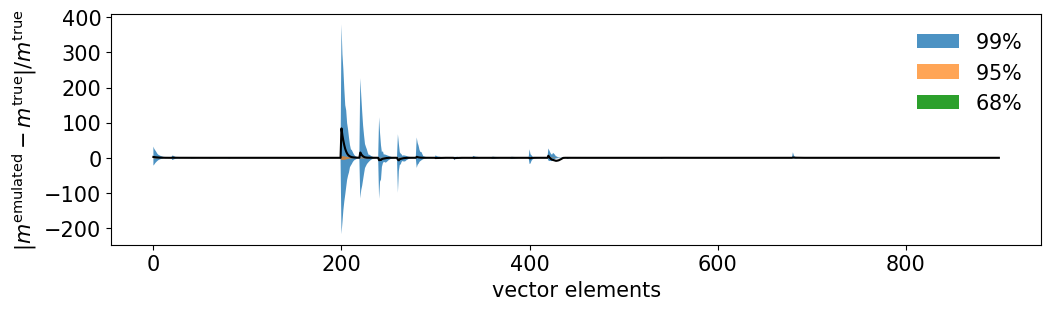

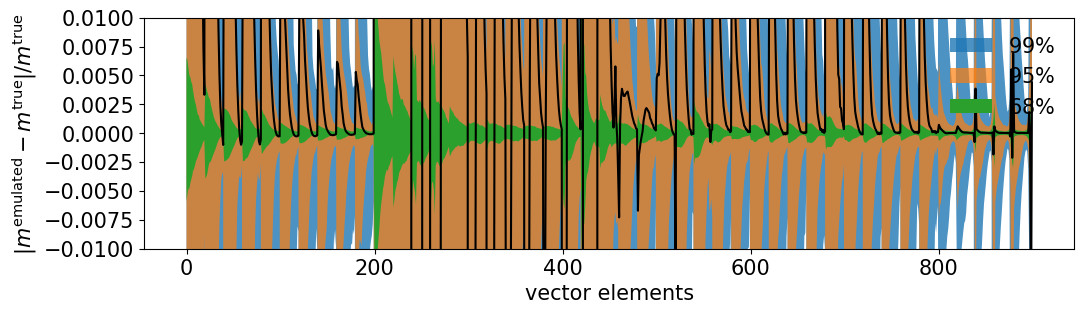

In [11]:
#####################################
#### Plot (emulated - true)/true ####
#####################################

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$68\%$', alpha = 1)
plt.plot(bins, mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.show()

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$68\%$', alpha = 1)
plt.plot(bins, mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.01,0.01)
plt.show()

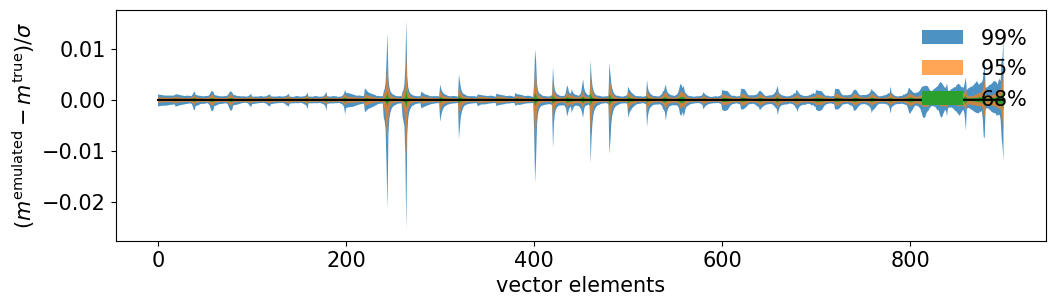

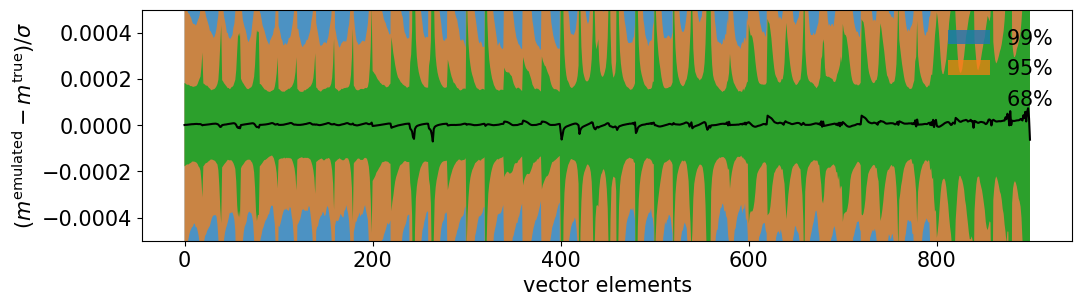

In [14]:
##############################################
#### Plot (emulated - true)/standard dev. ####
##############################################

percentiles1 = np.percentile(diff_std, [50-34, 50+34],axis=0) 
percentiles2 = np.percentile(diff_std, [50-(95/2), 50+(95/2)], axis=0) 
percentiles3 = np.percentile(diff_std, [50-(99/2), 50+(99/2)], axis=0)

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$68\%$', alpha = 1)
plt.plot(bins, mean_diff_std,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$ (m^{\mathrm{emulated}} - m^{\mathrm{true}})/  \sigma$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.show()

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$68\%$', alpha = 1)
plt.plot(bins, mean_diff_std,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$ (m^{\mathrm{emulated}} - m^{\mathrm{true}})/  \sigma$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.0005,0.0005)
plt.show()

##### Next we want perform a Fisher Analysis using the emulator. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [22]:
Om_shift = 0.001 #decide for a reasonable stepsize in Omega_m
w_shift = 0.001 #decide for a reasonable stepsize in w

# Determining the mean of the omega_m and w parameters
mean_omega_m = np.mean(parameters['omega_m'])
mean_w = np.mean(parameters['w'])

# Initializing two sets of parameters. One where omega_m is varied and another where w is varied. 
parameters_omega_m_varied = {'omega_m':[mean_omega_m + 2*Om_shift, mean_omega_m + Om_shift, mean_omega_m - Om_shift, mean_omega_m - 2*Om_shift],
               'w':[np.mean(test_params['w'])]*4,
               'As':[np.mean(test_params['As'])]*4,'omega_b':[np.mean(test_params['omega_b'])]*4}

parameters_w_varied  = {'omega_m':[np.mean(test_params['omega_m'])]*4,
               'w':[mean_w + 2*w_shift, mean_w + w_shift, mean_w - w_shift, mean_w - 2*w_shift],
               'As':[np.mean(test_params['As'])]*4,'omega_b':[np.mean(test_params['omega_b'])]*4}

# Undoing the normalzation performed when training the NN
feature_omega_m = (cp_nn.predictions_np(parameters_omega_m_varied) *maximum_feaure) + minimum_feature
feature_w = (cp_nn.predictions_np(parameters_w_varied) *maximum_feaure) + minimum_feature

# Calculating the derivative of omega_m and w
derivative_Om = (-feature_omega_m[0] + 8*feature_omega_m[1] - 8*feature_omega_m[2] + feature_omega_m[3]) / (12*Om_shift) # compute derivative
derivative_w = (-feature_w[0] + 8*feature_w[1] - 8*feature_w[2] + feature_w[3]) / (12*w_shift) # compute derivative

#### So lets compute the Fisher matrix with the corresponding covariance matrix of the paramters:

In [28]:
cov=np.load('data_4_assignment1/covariance.npy')  # loading in the given covariance matrix
inv_cov = inv(cov) # taking the inverse of the covariance matrix to be used when we calculate the components of the Fisher Matrix

#print(inv_cov.shape) 

# Calculating the Fisher Matrix
FoM_11 = derivative_Om.T @ inv_cov @ derivative_Om 
FoM_22 = derivative_w.T @ inv_cov @ derivative_w 
FoM_12 = derivative_Om.T @ inv_cov @ derivative_w 
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

print("Fisher Matrix:")
print(FoM_best)
print("")

print("Covariance Parameters Matrix:")
Cov_parameter = inv(FoM_best)
print(Cov_parameter)

print("")
print("Maximum Constraints:")
print(np.sqrt(np.diag(Cov_parameter)))


Fisher Matrix:
[[5560925.7208139  -204640.23611671]
 [-204640.23611671   10695.52831558]]

Covariance Parameters Matrix:
[[6.07720767e-07 1.16276744e-05]
 [1.16276744e-05 3.15972240e-04]]

Maximum Constraints:
[0.00077956 0.01777561]


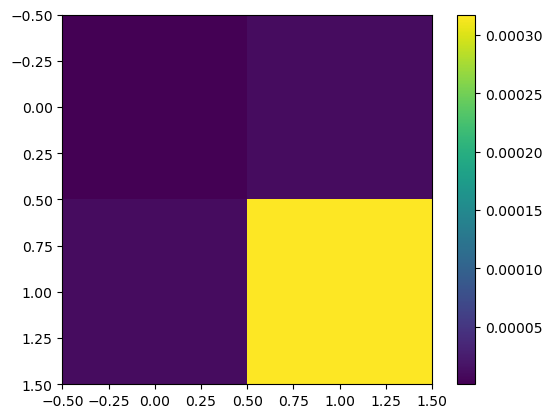

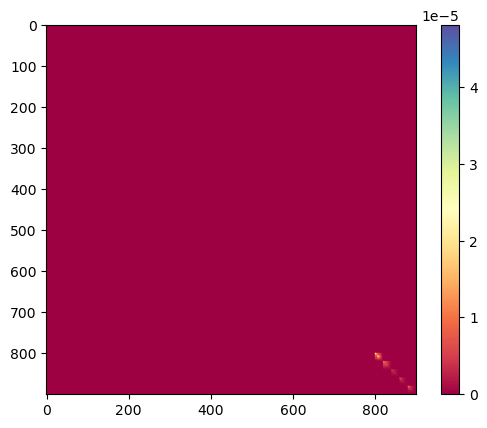

In [16]:
plt.imshow(Cov_parameter)
plt.colorbar()
plt.show()

plt.imshow(cov, cmap='Spectral')
plt.colorbar()
plt.show()

#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the a covarience on the PCA elements. Now it should get clear why you had to genereate the 100k multvariate Gaussian random variables. 

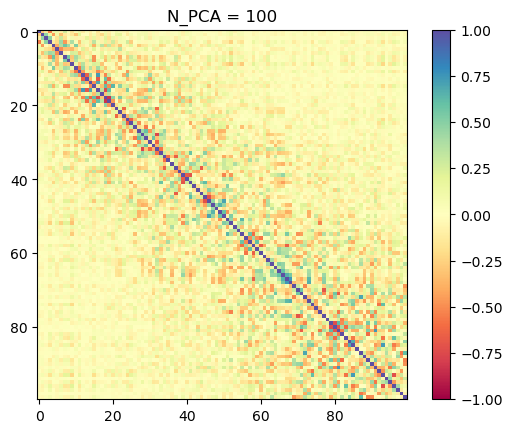

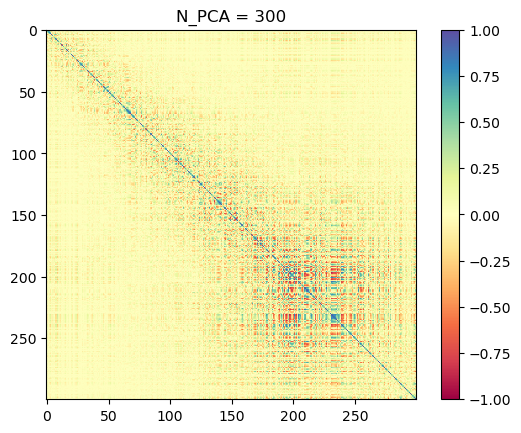

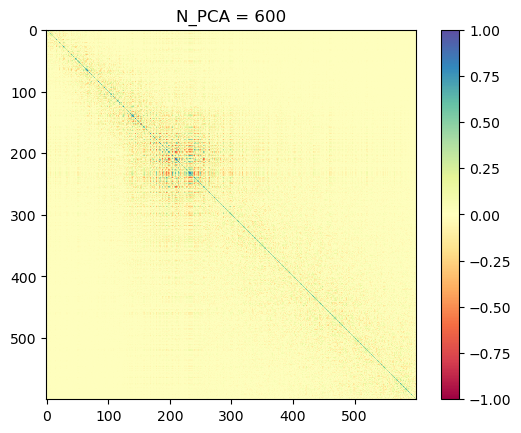

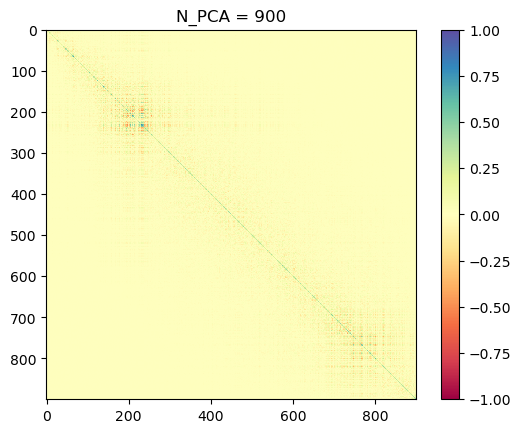

In [35]:
from sklearn.decomposition import PCA

models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element


def compute_cov_pca(N_pca):
    
    N_pca = N_pca # Decide how many PCA eigenvalues you want to use
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit_transform(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix
    return cov_pca

cov_pca_100 = compute_cov_pca(100)
cov_pca_300 = compute_cov_pca(300)
cov_pca_600 = compute_cov_pca(600)
cov_pca_900 = compute_cov_pca(900)

# Plotting
plt.imshow(cov_pca_100/np.outer(np.sqrt(np.diag(cov_pca_100)),np.sqrt(np.diag(cov_pca_100))),vmin=-1, cmap='Spectral')
plt.colorbar()
plt.title('N_PCA = 100')
plt.show()

plt.imshow(cov_pca_300/np.outer(np.sqrt(np.diag(cov_pca_300)),np.sqrt(np.diag(cov_pca_300))),vmin=-1, cmap='Spectral')
plt.colorbar()
plt.title('N_PCA = 300')
plt.show()

plt.imshow(cov_pca_600/np.outer(np.sqrt(np.diag(cov_pca_600)),np.sqrt(np.diag(cov_pca_600))),vmin=-1, cmap='Spectral')
plt.colorbar()
plt.title('N_PCA = 600')
plt.show()

plt.imshow(cov_pca_900/np.outer(np.sqrt(np.diag(cov_pca_900)),np.sqrt(np.diag(cov_pca_900))),vmin=-1, cmap='Spectral')
plt.colorbar()
plt.title('N_PCA = 900')
plt.show()
    

### Comments on Plots:

We see that using more PCA components (up to the max of 900, which would be using everything) there is less cross-correlation. In first plot, where 100 PCA components are used, we see there is alot of cross-terms (anything not the diagonal) with a greater spread moving away from the diagonals. As we increase the number of PCA components the cross-terms begin to vanish but there is a distinct square-like (?) pattern which moves further to the top left of the plot.

#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

In [36]:
from tqdm import tqdm

models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element
pca = PCA(n_components=900,svd_solver='full')

models_pca = pca.fit_transform(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation

# Rotating the covariance matrix
rotation_matrix = pca.components_.T
cov_pca = rotation_matrix.T @ cov @ rotation_matrix

paramter_constraints = []

for N_pca in tqdm(np.arange(1,900)):
    
    inv_cov_pca = inv(cov_pca[:N_pca,:N_pca]) # select the first N_pca elements

    parameters_omega_m_varied = {'omega_m':[mean_omega_m + 2*Om_shift, mean_omega_m + Om_shift, mean_omega_m - Om_shift, mean_omega_m - 2*Om_shift],
                'w':[np.mean(test_params['w'])]*4,
                'As':[np.mean(test_params['As'])]*4,'omega_b':[np.mean(test_params['omega_b'])]*4}

    parameters_w_varied  = {'omega_m':[np.mean(test_params['omega_m'])]*4,
                'w':[mean_w + 2*w_shift, mean_w + w_shift, mean_w - w_shift, mean_w - 2*w_shift],
                'As':[np.mean(test_params['As'])]*4,'omega_b':[np.mean(test_params['omega_b'])]*4}

    # Obtaining the NN predictions, unnormalzing and performing the PCA tranformation
    feature_omega_m_pca = pca.transform( (cp_nn.predictions_np(parameters_omega_m_varied)  *maximum_feaure) + minimum_feature)[:,:N_pca]
    feature_w_pca = pca.transform( (cp_nn.predictions_np(parameters_w_varied)  *maximum_feaure) + minimum_feature)[:,:N_pca]

    # Calculating the derivative of Om_pca and w_pca
    derivative_Om_pca = (-feature_omega_m_pca[0] + 8*feature_omega_m_pca[1] - 8*feature_omega_m_pca[2] + feature_omega_m_pca[3]) / (12*Om_shift) # compute derivative
    derivative_w_pca = (-feature_w_pca[0] + 8*feature_w_pca[1] - 8*feature_w_pca[2] + feature_w_pca[3]) / (12*w_shift) # compute derivativ

    # Computing the Fisher Matrix
    FoM_11 = derivative_Om_pca.T @ inv_cov_pca @ derivative_Om_pca 
    FoM_22 = derivative_w_pca.T @ inv_cov_pca @ derivative_w_pca 
    FoM_12 = derivative_Om_pca.T @ inv_cov_pca @ derivative_w_pca 
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

    # Compute the covariance parameter matrix
    Cov_parameter_pca = inv(FoM_best_pca)

    # Appending the parameter constraints to the list 
    paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))

paramter_constraints = np.array(paramter_constraints)

100%|██████████| 899/899 [00:33<00:00, 26.46it/s]


In [37]:
# Saving the result out
np.savetxt('data_4_assignment2/PCA_parameter_contraints_normalized_900_v3.txt',paramter_constraints)

In [38]:
# Loading in parameter constraints 
paramter_constraints = np.loadtxt('data_4_assignment2/PCA_parameter_contraints_normalized_900_v3.txt')

### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power.

In [39]:
# obtaining the values for the maximum constraining power for Om and w
max_constrain_power_omega_m, max_constrain_power_w = np.sqrt(np.diag(Cov_parameter)) 

print(r"The max contraining power for Omega_m is:", max_constrain_power_omega_m)
print(r"The max contraining power for w is:", max_constrain_power_w)
print("")

ten_percent_constrain_power_omega_m, one_percent_constrain_power_omega_m = (1.1*max_constrain_power_omega_m), (1.01*max_constrain_power_omega_m)
ten_percent_constrain_power_w, one_percent_constrain_power_w = (1.1*max_constrain_power_w), (1.01*max_constrain_power_w)

print("Omega_m:")
print('The 10% constraining power for Omega_m is:',ten_percent_constrain_power_omega_m)
print('The 1% contraining pwoer for Omega_m is: ',one_percent_constrain_power_omega_m)

print("---------------------------------")
print("w:")
print('The 10% constraining power for w is:',ten_percent_constrain_power_w)
print('The 1% contraining pwoer for w is: ',one_percent_constrain_power_w)


The max contraining power for Omega_m is: 0.0007795644723530074
The max contraining power for w is: 0.01777560801161132

Omega_m:
The 10% constraining power for Omega_m is: 0.0008575209195883081
The 1% contraining pwoer for Omega_m is:  0.0007873601170765375
---------------------------------
w:
The 10% constraining power for w is: 0.019553168812772456
The 1% contraining pwoer for w is:  0.017953364091727434


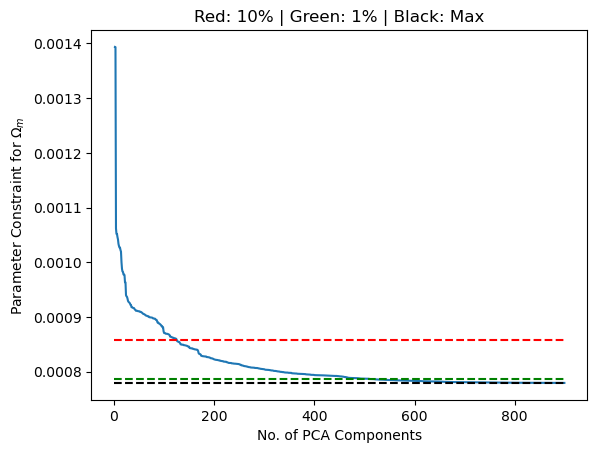

In [40]:
# Plotting the constraining power of Omega_m as a function of PCA components
plt.plot(np.arange(2,900), paramter_constraints[1:,0] )
plt.hlines( [ten_percent_constrain_power_omega_m, one_percent_constrain_power_omega_m, max_constrain_power_omega_m], 
           0, 900, linestyles='dashed', color=['r','g','k']) 
plt.ylabel(r'Parameter Constraint for $\Omega_{m}$')
plt.xlabel(r'No. of PCA Components')
plt.title('Red: 10% | Green: 1% | Black: Max')
plt.show()

In [29]:
# Determining the Number of PCA components required to reach 10% and 1% constraining power 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

ten_percent_PCA_number_omega_m = find_nearest(paramter_constraints[:,0], ten_percent_constrain_power_omega_m)
one_percent_PCA_number_omega_m = find_nearest(paramter_constraints[:,0], one_percent_constrain_power_omega_m)

print(r'10% at:', ten_percent_PCA_number_omega_m, r'| 1% at:',one_percent_PCA_number_omega_m)


10% at: 125 | 1% at: 501


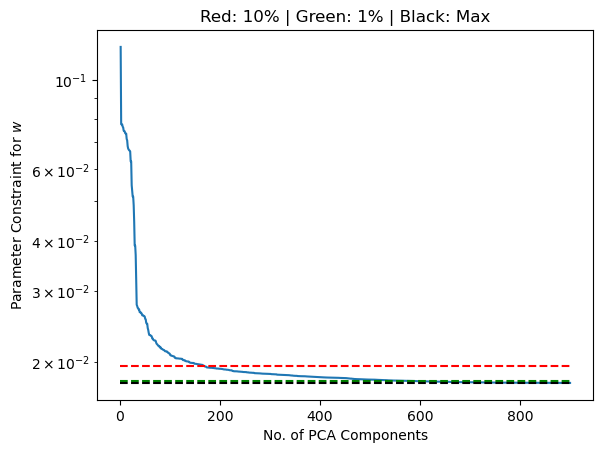

In [41]:
# Plotting the constraining power of w as a function of PCA components
plt.plot(np.arange(2,900), paramter_constraints[1:,1] )
plt.hlines( [ten_percent_constrain_power_w, one_percent_constrain_power_w, max_constrain_power_w], 
           0, 900, linestyles='dashed', color=['r','g','k']) 
plt.ylabel(r'Parameter Constraint for $w$')
plt.xlabel(r'No. of PCA Components')
plt.title('Red: 10% | Green: 1% | Black: Max')
plt.semilogy()
plt.show()

In [39]:
# Determining the Number of PCA components required to reach 10% and 1% constraining power 
ten_percent_PCA_number_w = find_nearest(paramter_constraints[:,1], ten_percent_constrain_power_w)
one_percent_PCA_number_w = find_nearest(paramter_constraints[:,1], one_percent_constrain_power_w)

print(r'10% at:', ten_percent_PCA_number_w, r'| 1% at:',one_percent_PCA_number_w)

10% at: 168 | 1% at: 602


### Summary of Results

$\Omega_{m}$:
 
| Constraining Power            |Number of PCA Components |
|-------------------|-------|
| Max (100%)        | 900   |
| 1.01 * Max        | 501   |
| 1.1 * Max         | 125   |


$w$:

| Constraining Power           | Number of PCA Components |
|-------------------|-------|
| Max (100%)        | 900   |
| 1.01 * Max        | 502   |
| 1.1 * Max         | 168   |


